## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import seaborn as sns
%matplotlib inline

In [3]:
# Task 1 Data
COUNTY = "./data/acs2015_county_data.csv"
# Task 2 Data
AAC_INTAKES_OUTCOMES = "./data/aac_intakes_outcomes.csv"

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

**A) You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?**

In [4]:
# Read file and drop 3 lines containing nan values
county_df = pd.read_csv(COUNTY).dropna().reset_index(drop=True)

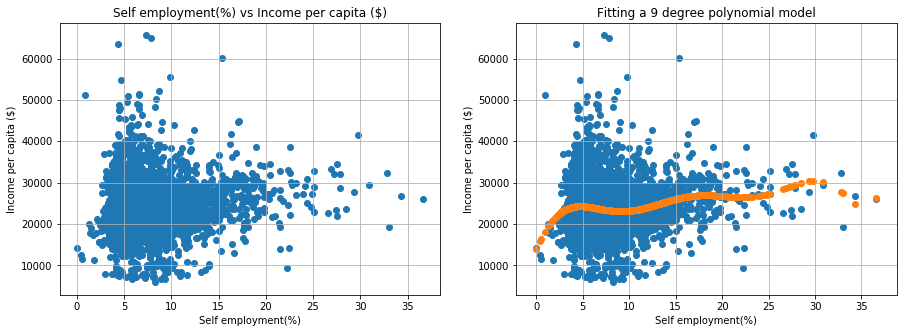

Correlation: 0.08678892594993486


In [5]:
self_employed = county_df.SelfEmployed.to_frame()
income_per_cap = county_df.IncomePerCap

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.scatter(x=self_employed, y=income_per_cap)
plt.xlabel("Self employment(%)")
plt.ylabel("Income per capita ($)")
plt.title("Self employment(%) vs Income per capita ($)")

plt.subplot(1, 2, 2)
plt.grid(True)
# Trying to fit a polynomial model only based on self_employment %
linear = LinearRegression(normalize=True)
poly = PolynomialFeatures(8)
self_employed_poly = poly.fit_transform(self_employed)
model = linear.fit(self_employed_poly, income_per_cap)  
predicted = model.predict(self_employed_poly)
plt.scatter(self_employed, income_per_cap, label="Truth")
plt.scatter(self_employed, predicted, label="Predicted")
plt.xlabel("Self employment(%)")
plt.ylabel("Income per capita ($)")
plt.title("Fitting a 9 degree polynomial model")
plt.show()

# Correlation
print("Correlation: {}".format(county_df.SelfEmployed.corr(county_df.IncomePerCap, method='pearson')))

There is no really dependency between self-employment rate and income per capita. As we can see in the scatter plot, there isn't really any visible relationship between the self-employment rate and the income per capita. We tried to find a relationship with a polynomial fit, but we did not achieve to find one. No, inhabitants in higher self-employment rate cities do not earn more. We rather notice that it is slightly frequent to higher values for income per capita when the self-employment rate is lower tan 10%, but there are not enough 'dots' to make it significant. We also plotted the correlation between the 2 variables, and it gave us a very poor correlation between the 2 variables.

**B) The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.**

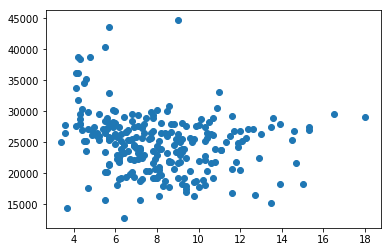

In [336]:
set_a = ['Wisconsin', 'Tennessee', 'Minnesota']
# Select these states only
A_states = county_df.loc[county_df.State.isin(set_a)]

plt.scatter(x=A_states.SelfEmployed, y=A_states.IncomePerCap)

**C) In which state within set A is the observed effect of self-employment on per-capita income the strongest?**

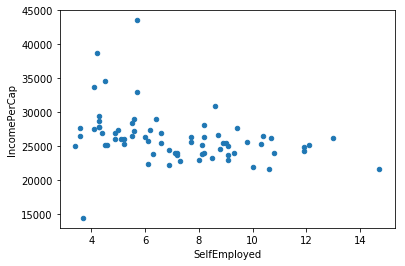

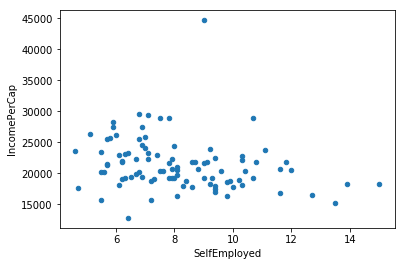

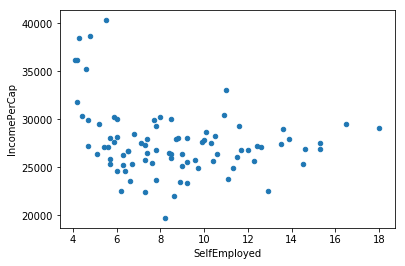

In [339]:
Wisconsin = county_df.loc[county_df.State == 'Wisconsin']
Tennessee = county_df.loc[county_df.State == 'Tennessee']
Minnesota = county_df.loc[county_df.State == 'Minnesota']

states = [Wisconsin, Tennessee, Minnesota]
for state in states:
    state.plot.scatter(x='SelfEmployed', y='IncomePerCap')

**D) Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.**

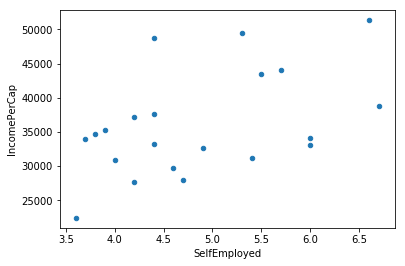

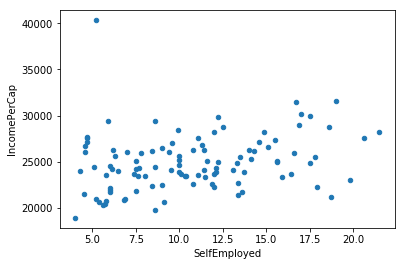

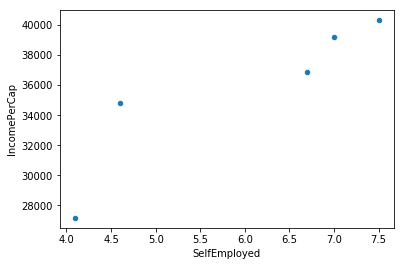

In [343]:
set_b = ['New Jersey', 'Kansas', 'Rhode Island']

New_Jersey = county_df.loc[county_df.State == 'New Jersey']
Kansas = county_df.loc[county_df.State == 'Kansas']
Rhode_Island = county_df.loc[county_df.State == 'Rhode Island']

states_b = [New_Jersey, Kansas, Rhode_Island]

for state in states_b:
    state.plot.scatter(x='SelfEmployed', y='IncomePerCap')

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

**A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.**

In [25]:
# Load dataset
adopt_df = pd.read_csv(AAC_INTAKES_OUTCOMES)

# Extract the features we will be woring with
working_features = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
                   'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', 'outcome_type']

adopt_df = adopt_df[working_features]

# Show features with nan
print("There are {} % of rows that have nan value.".format(len(adopt_df[adopt_df.isnull().any(axis=1)])/len(adopt_df)*100))

# Drop the nan columns
adopt_df = adopt_df.dropna().reset_index(drop=True)

There are 0.013806607089065167 % of rows that have nan value.


We can see that a few rows have nan values. We decide to drop these rows because these nan rows are very few in quantity and dropping them will not affect the final model.

In [26]:
# Convert to dummy-variable encoding
dummy_features = ['outcome_type', 'animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake', 'sex_upon_outcome']

# Take out outcometype-Adoption and the other dummy variables separately
adopt_dummies = pd.get_dummies(adopt_df[dummy_features[1:]])
outcome_dummies = pd.get_dummies(adopt_df.outcome_type)

# Concat the already-numerical-features with dummies --> full data
adopt_without_dummies = adopt_df.drop(dummy_features, axis=1)
adopt_data = adopt_dummies.merge(adopt_without_dummies, left_index=True, right_index=True)

In [41]:
def split_data(x, y, ratio=0.8, myseed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x.iloc[index_tr]
    x_te = x.iloc[index_te]
    y_tr = y.iloc[index_tr]
    y_te = y.iloc[index_te]
    return x_tr, x_te, y_tr, y_te

# Standardize the data
adopt_data_std = (adopt_data - adopt_data.mean()) / adopt_data.std()
# Split data into 80-20
x_tr, x_te, y_tr, y_te = split_data(adopt_data_std, outcome_dummies['Adoption'])

print("X (features) and Y (adoption) are paired by their index. Here is an example: the animal having these features: \n{} \n\nis adopted: \n{}".format(x_tr.iloc[0], y_tr.iloc[0]))

X (features) and Y (adoption) are paired by their index. Here is an example: the animal having these features: 
animal_type_Bird                 -0.065373
animal_type_Cat                  -0.767619
animal_type_Dog                   0.869522
animal_type_Other                -0.242458
intake_condition_Aged            -0.063408
intake_condition_Feral           -0.034003
intake_condition_Injured         -0.229837
intake_condition_Normal           0.370493
intake_condition_Nursing         -0.156943
intake_condition_Other           -0.042997
intake_condition_Pregnant        -0.024297
intake_condition_Sick            -0.201154
intake_type_Euthanasia Request   -0.056221
intake_type_Owner Surrender      -0.482173
intake_type_Public Assist        -0.258562
intake_type_Stray                 0.651339
intake_type_Wildlife             -0.213054
sex_upon_intake_Intact Female    -0.650811
sex_upon_intake_Intact Male       1.465184
sex_upon_intake_Neutered Male    -0.435643
sex_upon_intake_Spayed Femal

The above example shows the treated features (with standardizing) of an animal that is actually adopted. The below shows the untreated data of the same animal. The data is standardized since the question asks for standardization of each feature, but actually, standardizing the categorical data (having only 0 or 1) doesn't make much sense. We should only standardize data that we assume have a Gaussian distribution.

In [32]:
print("Here is the original data:")
adopt_df.iloc[69166]

Here is the original data:


animal_type                           Dog
intake_year                          2017
intake_condition                   Normal
intake_number                           1
intake_type                         Stray
sex_upon_intake               Intact Male
age_upon_intake_(years)         0.0821918
time_in_shelter_days              4.14514
sex_upon_outcome            Neutered Male
age_upon_outcome_(years)         0.164384
outcome_type                     Adoption
Name: 69166, dtype: object

**B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.**

In [33]:
# Create logistic model and predict y-labels. By default the decision threshold is 0.5.
logistic = LogisticRegression(solver='lbfgs')
model = logistic.fit(x_tr, y_tr)
y_pred = model.predict(x_te)

# Plot confusion matrix
# Note in sklearn: 
# True positive: cm[1,1]
# False positive: cm[0,1]
# False negative: cm[1,0]
# True negative: cm[0,0]

cm = confusion_matrix(y_te, y_pred)
cm

array([[7664, 1576],
       [1258, 5435]])

In [34]:
def test_scores(x_te, y_te, threshold, verbose=False):
    """
    Function to calculate accuracy, precision, recall and F1 score according to specific threshold for 
    positive or negative class
    """
    y_pred = np.where(model.predict_proba(x_te)[:,1] > threshold, 1, 0)
    cm = confusion_matrix(y_te, y_pred)
    
    # Calculate accuracy (same for +ve and -ve class)
    # (true +ve + true -ve / (all))
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    
    # Calculate precision 
    #(true +ve / (true +ve + false +ve))
    precision_pos = cm[1,1] / float(cm[1,1] + cm[0,1])
    #(true -ve / (true -ve + false -ve))
    precision_neg = cm[0, 0] / float(cm[0,0] + cm[1,0])
    
    # Calculate recall 
    #(true +ve / (true +ve + false -ve))
    recall_pos = cm[1,1] / float(cm[1,1] + cm[1,0])
    #(true -ve / (true -ve + false +ve))
    recall_neg = cm[0,0] / float(cm[0,0] + cm[0,1])
    
    # Calculate F1 score  2*((precision*recall)/(precision+recall))
    F1_pos = 2*(precision_pos*recall_pos) / (precision_pos + recall_pos)
    F1_neg = 2*(precision_neg*recall_neg) / (precision_neg + recall_neg)
    if verbose:
        print("For threshold {}, \nAccuracy: {:.4f}, \nPrecision (+ve): {:.4f}, Precision (-ve): {:.4f} \nRecall (+ve): {:.4f}, Recall (-ve): {:.4f}, \nF1 (+ve): {:.4f}, F1 (-ve): {:.4f}\n"\
              .format(threshold, accuracy, precision_pos, precision_neg, recall_pos, recall_neg, F1_pos, F1_neg))
    return accuracy, precision_pos, precision_neg, recall_pos, recall_neg, F1_pos, F1_neg

accuracy, precision_pos, precision_neg, recall_pos, recall_neg, F1_pos, F1_neg = test_scores(x_te, y_te, 0.5, True)


For threshold 0.5, 
Accuracy: 0.8221, 
Precision (+ve): 0.7752, Precision (-ve): 0.8590 
Recall (+ve): 0.8120, Recall (-ve): 0.8294, 
F1 (+ve): 0.7932, F1 (-ve): 0.8440



In [35]:
# Test with threshold from 0 to 1
accuracies = []
precisions_pos = []
recalls_pos = []
F1s_pos = []
precisions_neg = []
recalls_neg = []
F1s_neg = []
thresholds = np.arange(0, 11, 1) / 10
for threshold in thresholds:
    accuracy, precision_pos, precision_neg, recall_pos, recall_neg, F1_pos, F1_neg = test_scores(x_te, y_te, threshold)
    accuracies.append(accuracy)
    precisions_pos.append(precision_pos)
    recalls_pos.append(recall_pos)
    F1s_pos.append(F1_pos)
    precisions_neg.append(precision_neg)
    recalls_neg.append(recall_neg)
    F1s_neg.append(F1_neg)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5,1,'Negative metrics')

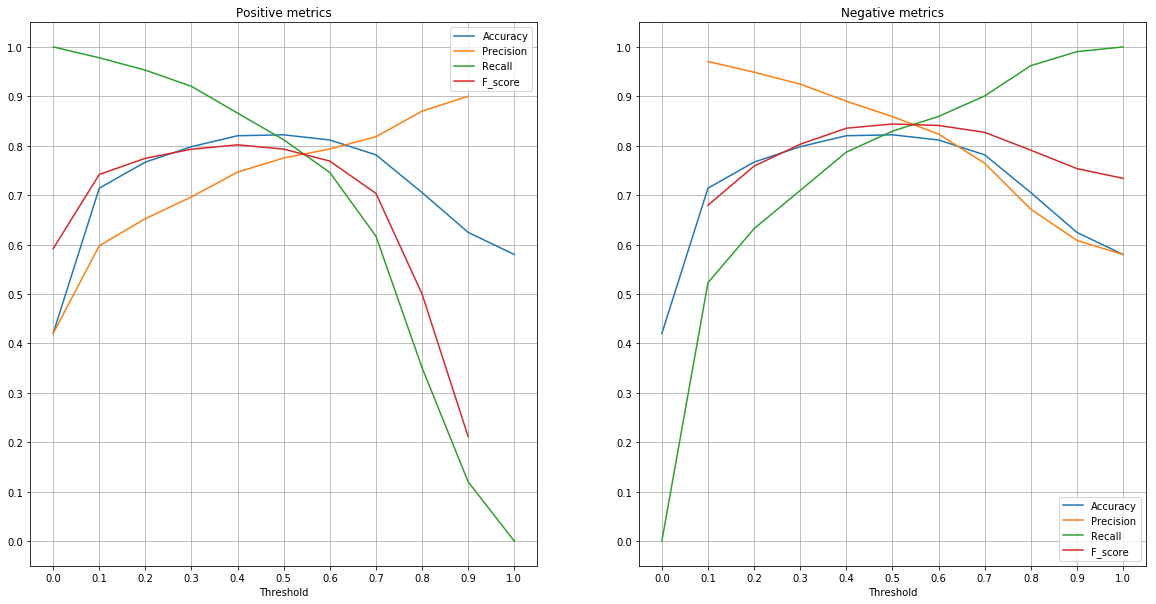

In [37]:
# Plot 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.grid(True)
plt.xticks(thresholds)
plt.yticks(thresholds)
plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, precisions_pos, label="Precision")
plt.plot(thresholds, recalls_pos, label="Recall")
plt.plot(thresholds, F1s_pos, label="F_score")
plt.xlabel("Threshold")
plt.legend(["Accuracy", 'Precision', 'Recall', 'F_score'])
plt.title('Positive metrics')

plt.subplot(1,2,2)
plt.grid(True)
plt.xticks(thresholds)
plt.yticks(thresholds)
plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, precisions_neg, label="Precision")
plt.plot(thresholds, recalls_neg, label="Recall")
plt.plot(thresholds, F1s_neg, label="F_score")
plt.xlabel("Threshold")
plt.legend(["Accuracy", 'Precision', 'Recall', 'F_score'])
plt.title('Negative metrics')


As we observe, for higher recall, there are lower precision (as the explication in class).

In [246]:
print("(In train set), there are {}% of animals that are adopted ({} / {})".format((y_tr.sum()/len(y_tr)), y_tr.sum(), len(y_tr)))
print("(In test set), there are {}% of animals that are adopted ({} / {})".format((y_te.sum()/len(y_te)), y_te.sum(), len(y_te)))

(In train set), there are 0.42212214411247806% of animals that are adopted (26901 / 63728)
(In test set), there are 0.42007154961400867% of animals that are adopted (6693 / 15933)


If they make a decision to sleep an animal, we want to make sure that if the prediction says this animal will not be adopted, it will actually not be adopted. Therefore, we want the negative precision metric -- the likelihood that a to-be-slept animal to be indeed not adopted (true negative / (true negative + false negative)). A high negative precision (orange line in Negative Metrics subplot) would be necessary in this scenario.

**C) Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.**

We will use accuracy to evaluation the performance of the model. We fix the threshold to 0.5, since in the graphs above we see that the accuracy is at its maximum when the threshold is 0.5.

In [44]:
# Create logistic model and predict y-labels.
logistic = LogisticRegression(solver='lbfgs')

def get_accuracy(x_tr, y_tr, x_te, y_te threshold=0.5):
    model = logistic.fit(x_tr, y_tr)
    y_pred = model.predict(x_te)
    cm = confusion_matrix(y_te, y_pred)
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    return accuracy

def build_k_indices(y, k_fold, seed=1):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

# 5 fold cross-validation
def cross_validation(y, x, k_indices, k):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # form data with polynomial degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression
    w = ridge_regression(y_tr, tx_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te,w

possible_ks = [1, 5, 10, 15, 20, 25, 30]
features = list(x_tr.columns)

# Backward greedy selection
for k in range(32, 0, -1):
#     accuracies = []
    feature_least_significant = ""
    score = -np.inf
    # Go through all the features and test for accuracy without the feature
    for i, feature in enumerate(features):
        features_without_feature_i = features[:i] + features[i+1:]
        # Perform 5-fold cross-validation
        n_fold = 5
        accuracies = []
        # split data in k fold
        k_indices = build_k_indices(y, n_fold, seed)
        for n in range(n_fold):
            accuracy = cross_validation(y, x, k_indices, n)
            accuracies.append(accuracy)
            
    # Drop feature with the least accuracy
    features.remove(feature)
    #print(len(features_without_feature_i))

SyntaxError: invalid syntax (<ipython-input-44-cfabb48502c8>, line 4)

D) Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

In [76]:
logistic = LogisticRegression(solver='lbfgs')

def get_accuracy(tx_tr, ty_tr, tx_te, ty_te, threshold=0.5):
    model = logistic.fit(tx_tr, ty_tr)
    y_pred = np.where(model.predict_proba(tx_te)[:,1] > threshold, 1, 0)
    cm = confusion_matrix(ty_te, y_pred)
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    return accuracy

def get_rfc_accuracy(tx_tr, ty_tr, tx_te, ty_te, rfc):
    model = rfc.fit(tx_tr, ty_tr)
    y_pred = model.predict(tx_te)
    cm = confusion_matrix(ty_te, y_pred)
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    return accuracy

def build_k_indices(y, k_fold, seed=1):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

# 5 fold cross-validation
def cross_validation(y_tr, x_tr, rfc=None, use_rfc=False):
    """perform 5 fold cross_validation"""
    x = x_tr.values
    y = y_tr.values

    k_fold = 5
    accuracies = []
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold)
    for k in range(k_fold):
        # get k'th subgroup in test, others in train
        te_indice = k_indices[k]
        tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
        # Split into x,y test (1/5) / x,y train (4/5)
        ty_te = y[te_indice]
        ty_tr = y[tr_indice]
        tx_te = x[te_indice]
        tx_tr = x[tr_indice]
        # get accuracy
        if use_rfc:
            accuracy = get_rfc_accuracy(tx_tr, ty_tr, tx_te, ty_te, rfc)
        else:
            accuracy = get_accuracy(tx_tr, ty_tr, tx_te, ty_te)
        accuracies.append(accuracy)
    return sum(accuracies)/len(accuracies)

In [89]:
def grid_search(y_tr, x_tr, n_estimators, max_depths):
    """Algorithm for grid search."""
    accuracies = dict()
    # compute loss for each combination of w0 and w1.
    for i, estimator in enumerate(n_estimators):
        for j, depth in enumerate(max_depths):
            rfc = RandomForestClassifier(n_estimators=estimator, max_depth=depth)
            accuracies[(estimator, depth)] = cross_validation(y_tr, x_tr, rfc, use_rfc=True)
            print("Accuracy: {} for max_depth {}, n_estimator {}".format(accuracies[(estimator, depth)], depth, estimator))
    return accuracies

In [90]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [1, 10, 50, 100]
max_depths = [1, 10, 50, 100]
rfc = RandomForestClassifier(n_estimators=50, max_depth=10)
accuracies = grid_search(y_tr, x_tr, n_estimators, max_depths)


Accuracy: 0.59447626520204 for max_depth 1, n_estimator 1
Accuracy: 0.8197567673597488 for max_depth 10, n_estimator 1
Accuracy: 0.8053040408003138 for max_depth 50, n_estimator 1
Accuracy: 0.8053040408003138 for max_depth 100, n_estimator 1
Accuracy: 0.6014123185562965 for max_depth 1, n_estimator 10
Accuracy: 0.8457905060808161 for max_depth 10, n_estimator 10
Accuracy: 0.8260965084346804 for max_depth 50, n_estimator 10
Accuracy: 0.826300510003923 for max_depth 100, n_estimator 10
Accuracy: 0.6025892506865438 for max_depth 1, n_estimator 50
Accuracy: 0.8488819144762653 for max_depth 10, n_estimator 50
Accuracy: 0.8308356218124755 for max_depth 50, n_estimator 50
Accuracy: 0.8310396233817183 for max_depth 100, n_estimator 50
Accuracy: 0.5838367987446057 for max_depth 1, n_estimator 100
Accuracy: 0.8495566888976069 for max_depth 10, n_estimator 100
Accuracy: 0.8315103962338171 for max_depth 50, n_estimator 100
Accuracy: 0.8312436249509612 for max_depth 100, n_estimator 100


In [92]:
# Find the best parameters for random forest
best_param = max(accuracies, key=accuracies.get)
print("The best parameters (n_estimator, max_depths) : {}".format(best_param))

The best parameters (n_estimator, max_depths) : (100, 10)


In [69]:
# Let's train using the best parameters
randomforest = RandomForestClassifier(n_estimators = 50, max_depth = 10)
model = randomforest.fit(x_tr, y_tr)
y_pred = randomforest.predict(x_te)
cm_rf = confusion_matrix(y_te, y_pred)

# For logistic


array([[7619, 1621],
       [ 769, 5924]])

In [54]:
confusion_matrix(y_te, y_pred)

array([[7573, 1667],
       [ 729, 5964]])

In [57]:
confusion_matrix(y_te, y_pred)

array([[7815, 1425],
       [1245, 5448]])

In [60]:
confusion_matrix(y_te, y_pred)

array([[7814, 1426],
       [1258, 5435]])

In [63]:
confusion_matrix(y_te, y_pred)

array([[7876, 1364],
       [1420, 5273]])

In [66]:
confusion_matrix(y_te, y_pred)

array([[7553, 1687],
       [ 704, 5989]])